In [1]:
from django.shortcuts import render, redirect, get_object_or_404
import os
import cv2
import json
import numpy as np
import librosa
from moviepy.editor import VideoFileClip
import tensorflow as tf
from keras.models import load_model

## Audio Process

In [2]:
def extract_audio(video_path, audio_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = video_clip.audio
    audio_clip.write_audiofile(audio_path, verbose=False, logger=None)
    video_clip.close()
    return audio_path

In [3]:
def preprocess_audio(audio_path, sample_rate=22050, n_fft=2048, hop_length=512, n_mels=130, segment_duration=3):
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    segment_length = int(sr * segment_duration)
    segments = []
    num_segments = len(audio) // segment_length
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        segment = audio[start_idx:end_idx]
        mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        segments.append(mel_spectrogram_db)
    return np.array(segments)

## Video Process

In [4]:
import cv2
import numpy as np
import threading
import queue

def preprocess_video_every_3_seconds(video_path: str, frame_size: tuple, frame_rate=3):
    """
    Extracts frames every 3 seconds from a video file, resizing them to frame_size and converting to grayscale.
    
    Args:
    video_path (str): Path to the video file.
    frame_size (tuple): Size (height, width) to resize frames.
    frame_rate (int): Number of frames to extract per second within the 3-second window.

    Returns:
    List[numpy.ndarray]: List of sequences, where each sequence is a numpy array of shape (num_frames, height, width, 1).
    """
    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    interval_frames = int(fps * 3)
    target_frames = int(frame_rate * 3)
    sequences = []

    def read_frames(q):
        while True:
            success, frame = vidcap.read()
            if not success:
                q.put(None)
                break
            q.put(frame)

    frame_queue = queue.Queue(maxsize=100)
    threading.Thread(target=read_frames, args=(frame_queue,)).start()

    while True:
        frames = []
        for _ in range(interval_frames):
            frame = frame_queue.get()
            if frame is None:
                break
            frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_AREA)
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = np.expand_dims(gray_frame, axis=-1)
            gray_frame = gray_frame.astype(np.float32) / 255.0
            frames.append(gray_frame)
        
        if len(frames) < interval_frames:
            break
        
        sequences.append(np.array(frames[:target_frames]))
    
    vidcap.release()
    return np.array(sequences)

## PipeLine

In [5]:
def pipeline_video(video_path:str):

    if not os.path.exists(video_path):
        print(f"Video Not Found : {video_path}")
        return
    
    audio = extract_audio(video_path, './test.wav')
    audio = preprocess_audio(audio)

    video = preprocess_video_every_3_seconds(video_path, (256, 256), 3)

    print(len(video))
    print(len(audio))

    video_model = load_model("video_3D_model.h5")
    audio_model = load_model("audio_comp_model.h5")

    video_output = video_model.predict(video)
    audio_output = audio_model.predict(audio)
    
    return video_output, audio_output

## Process Pipeline

In [6]:
video_path = "Pipeline/test.mp4"
test_data = pipeline_video(video_path)

print(test_data)

65
65
3/3 [==============================] - 0s 34ms/step
(array([[0.32927054, 0.6664482 , 0.00428132],
       [0.3264644 , 0.66929924, 0.0042363 ],
       [0.6602999 , 0.08235005, 0.2573501 ],
       [0.6541531 , 0.08066639, 0.26518056],
       [0.7882257 , 0.15867722, 0.05309708],
       [0.4611817 , 0.53188646, 0.00693184],
       [0.25524825, 0.74158657, 0.00316517],
       [0.1660884 , 0.8320011 , 0.0019104 ],
       [0.7891783 , 0.15640026, 0.05442138],
       [0.7064947 , 0.09199654, 0.20150869],
       [0.65657645, 0.32704672, 0.01637683],
       [0.7652363 , 0.11130536, 0.12345829],
       [0.7884789 , 0.15827233, 0.05324885],
       [0.7107081 , 0.0925782 , 0.19671379],
       [0.39405155, 0.6005777 , 0.00537077],
       [0.583272  , 0.06857035, 0.34815764],
       [0.7882539 , 0.15872213, 0.05302399],
       [0.78308314, 0.12241916, 0.09449768],
       [0.56484336, 0.42464167, 0.01051498],
       [0.6797782 , 0.301773  , 0.0184488 ],
       [0.78695256, 0.16169259, 0.0513548

In [7]:
video_res = test_data[0]
audio_res = test_data[1]

In [8]:
tmp = audio_res.copy()

In [9]:
video_res.shape

(65, 3)

In [10]:
audio_res.shape

(65, 2)

In [11]:
new_tmp = np.zeros((tmp.shape[0], tmp.shape[1] + 1))

for i, audio_data in enumerate(tmp):
    half_value = audio_data[1] / 2
    new_tmp[i][0] = audio_data[0]
    new_tmp[i][1] = half_value
    new_tmp[i][2] = half_value

In [12]:
print(new_tmp[:5])

[[0.08363988 0.45818007 0.45818007]
 [0.37758955 0.31120524 0.31120524]
 [0.33259228 0.33370388 0.33370388]
 [0.19666874 0.40166563 0.40166563]
 [0.01726399 0.491368   0.491368  ]]


In [13]:
def get_values_and_indices(arr):
    result = []
    for i, row in enumerate(arr):
        for j, val in enumerate(row):
            result.append((i, j, val))
    return result

max_values_and_indices = get_values_and_indices(new_tmp)
print(max_values_and_indices)

[(0, 0, 0.08363988250494003), (0, 1, 0.4581800699234009), (0, 2, 0.4581800699234009), (1, 0, 0.37758955359458923), (1, 1, 0.3112052381038666), (1, 2, 0.3112052381038666), (2, 0, 0.33259227871894836), (2, 1, 0.333703875541687), (2, 2, 0.333703875541687), (3, 0, 0.19666874408721924), (3, 1, 0.4016656279563904), (3, 2, 0.4016656279563904), (4, 0, 0.017263993620872498), (4, 1, 0.49136799573898315), (4, 2, 0.49136799573898315), (5, 0, 0.052462127059698105), (5, 1, 0.473768949508667), (5, 2, 0.473768949508667), (6, 0, 0.05514900013804436), (6, 1, 0.4724254906177521), (6, 2, 0.4724254906177521), (7, 0, 0.055489055812358856), (7, 1, 0.4722554683685303), (7, 2, 0.4722554683685303), (8, 0, 0.008727293461561203), (8, 1, 0.49563637375831604), (8, 2, 0.49563637375831604), (9, 0, 0.079900361597538), (9, 1, 0.4600498080253601), (9, 2, 0.4600498080253601), (10, 0, 0.15119194984436035), (10, 1, 0.4244040250778198), (10, 2, 0.4244040250778198), (11, 0, 0.24423395097255707), (11, 1, 0.37788301706314087),

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def get_max_values_and_indices(arr):
    result = []
    for i, row in enumerate(arr):
        max_val = round(np.max(row), 5)
        max_idx = np.argmax(row)
        result.append((i, max_idx, max_val))
    return result

max_values_and_indices = get_max_values_and_indices(new_tmp)
print(max_values_and_indices)


[(0, 1, 0.45818), (1, 0, 0.37759), (2, 1, 0.3337), (3, 1, 0.40167), (4, 1, 0.49137), (5, 1, 0.47377), (6, 1, 0.47243), (7, 1, 0.47226), (8, 1, 0.49564), (9, 1, 0.46005), (10, 1, 0.4244), (11, 1, 0.37788), (12, 1, 0.47362), (13, 1, 0.43647), (14, 1, 0.45321), (15, 1, 0.46559), (16, 1, 0.44355), (17, 1, 0.33811), (18, 1, 0.35732), (19, 1, 0.4838), (20, 1, 0.37987), (21, 1, 0.49441), (22, 1, 0.4784), (23, 1, 0.4802), (24, 1, 0.46611), (25, 1, 0.46744), (26, 0, 0.99965), (27, 1, 0.4775), (28, 0, 0.9558), (29, 0, 0.95879), (30, 1, 0.47873), (31, 1, 0.42958), (32, 1, 0.46908), (33, 0, 0.99918), (34, 0, 0.99936), (35, 0, 0.95242), (36, 0, 0.44687), (37, 1, 0.38549), (38, 1, 0.4082), (39, 1, 0.47023), (40, 1, 0.46296), (41, 1, 0.46547), (42, 1, 0.40704), (43, 1, 0.45772), (44, 1, 0.33363), (45, 0, 0.99631), (46, 0, 0.62341), (47, 1, 0.4037), (48, 0, 0.63174), (49, 1, 0.33755), (50, 0, 0.85015), (51, 1, 0.4147), (52, 0, 0.81823), (53, 0, 0.97828), (54, 0, 0.99982), (55, 0, 0.99769), (56, 0, 0.9

In [16]:
def visualize_max_values(max_values_and_indices):
    indices = [i for i, _ in enumerate(max_values_and_indices)]
    max_vals = [val for _, val in max_values_and_indices]
    colors = [idx for idx, _ in max_values_and_indices]

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(indices, max_vals, c=colors, cmap='viridis')
    plt.colorbar(scatter, label='Index')
    plt.xlabel('List Index')
    plt.ylabel('Max Value')
    plt.title('Max Values from Rows of the Array')
    plt.show()

# visualize_max_values(max_values_and_indices)

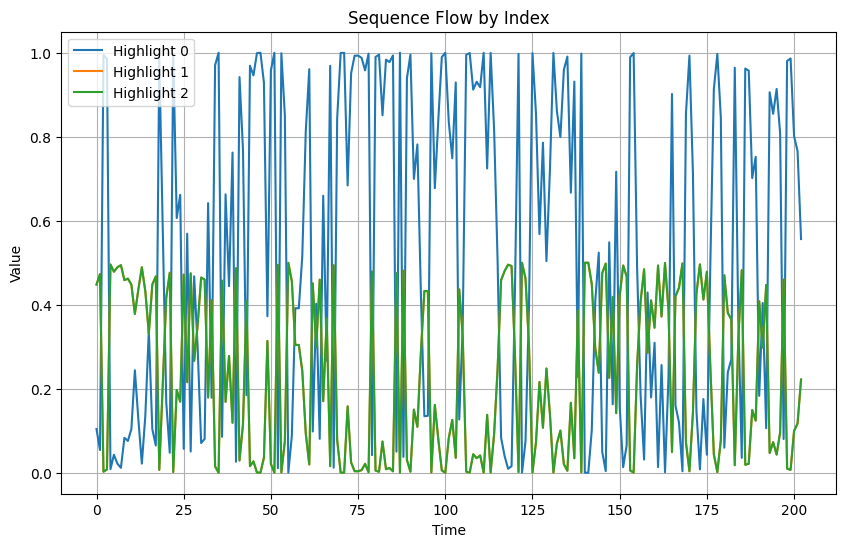

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
def plot_sequence(data):
    plt.figure(figsize=(10, 6))
    
    for idx in range(data.shape[1]):
        plt.plot(data[:, idx], label=f'Highlight {idx}')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Sequence Flow by Index')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sequence(new_tmp)


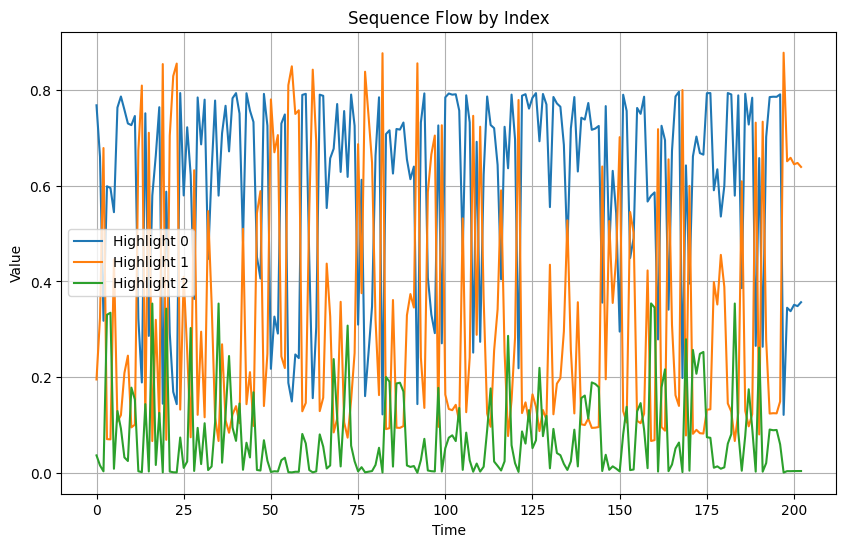

In [ ]:
plot_sequence(video_res)

In [ ]:
22//3

7

In [17]:
import cv2
import numpy as np

def get_max_values_and_indices(output, length = 15):
    result = []
    video_len = length//3
    for i, row in enumerate(output):
        max_val = round(np.max(row), video_len)
        max_idx = np.argmax(row)
        result.append((i, max_idx, max_val))
        
    sorted_data = sorted(result, key=lambda x: (x[1], x[2]), reverse=True)
    sorted_data = sorted(sorted_data[:5], key=lambda x: x[0])
    return sorted_data

def preprocess_shorts(video_path: str, label: list, output_path: str):
    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    interval = int(fps * 3)  # 3초 단위로 분리
    sequences = []

    for lbl in label:
        index = lbl[0]
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, index * interval)
        frames = []

        for _ in range(interval):
            success, frame = vidcap.read()
            if not success:
                break
            frames.append(frame)
        
        if len(frames) == interval:
            sequences.extend(frames)
    
    if sequences:
        height, width, layers = sequences[0].shape
        size = (width, height)
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

        for frame in sequences:
            out.write(frame)
        
        out.release()
    
    vidcap.release()

In [18]:
sorted_data = get_max_values_and_indices(new_tmp)

In [19]:
preprocess_shorts('Pipeline/test.mp4', sorted_data, "/Users/idaeho/Desktop/shorts.mp4")